In [1]:
from functions import intodf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.metrics import roc_curve, auc, log_loss, roc_auc_score


c:\Users\zyj25\AppData\Local\Programs\Python\Python312\Lib\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Light GBM
1. First testing parameters using CV with **original data (8columns)**

Data cleaning: defining df1,2,3 for image1,2,3

In [2]:
df3 = intodf('O013257.npz') #image3 - test
df2 = intodf('O013490.npz') #image2 - train
df1 = intodf('O012791.npz') #image1 - train

# Drop label=0 since they are of no use.
df1 = df1[df1['label'] != 0]
df2 = df2[df2['label'] != 0]
df3 = df3[df3['label'] != 0]

In [3]:
# Define features and labels for each
X_df1 = df1.drop(columns=["X", "Y", "label"])
y_df1 = df1["label"]
X_df2 = df2.drop(columns=["X", "Y", "label"])
y_df2 = df2["label"]
X_test = df3.drop(columns=["X", "Y", "label"])
y_test = df3["label"]

# Full training set for final retraining
df_train = pd.concat([df1, df2])
X_train_full = df_train.drop(columns=["X", "Y", "label"])
y_train_full = df_train["label"]

In [4]:
#Light GBM
# Hyperparameter grid
param_grid = {
    'num_leaves': [7, 15, 31],
    'learning_rate': [0.01, 0.05, 0.1, 0.15]
}

# Base parameters
base_params = {
    'objective': 'binary',
    'metric': 'binary_error',
    'boosting_type': 'gbdt',
    'feature_fraction': 0.7,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'max_bin': 127,
    'verbose': -1  # Silence all LightGBM output
}

###### 2-Fold CV setup #######
folds = [(X_df1, y_df1, X_df2, y_df2), (X_df2, y_df2, X_df1, y_df1)]

# Hyperparameter tuning
best_params = None
best_avg_val_error = float('inf')

## Grid search for the 9 combinations of hyperparameters
for num_leaves in param_grid['num_leaves']:
    for learning_rate in param_grid['learning_rate']:
        params = base_params.copy()
        params['num_leaves'] = num_leaves
        params['learning_rate'] = learning_rate
        
        val_errors = []
        print(f"Testing: num_leaves={num_leaves}, learning_rate={learning_rate}")
        
        for X_train, y_train, X_valid, y_valid in folds: ## for each fold train with one df, validate with another
            train_data = lgb.Dataset(X_train, label=y_train)
            valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)
            
            model = lgb.train(
                params,
                train_data,
                num_boost_round=500,
                valid_sets=[valid_data],
                valid_names=['valid'],
                callbacks=[lgb.early_stopping(20, verbose=False)]  
            )
            val_error = model.best_score['valid']['binary_error']
            val_errors.append(val_error)
        
        avg_val_error = np.mean(val_errors)
        print(f"Average Validation Error: {avg_val_error:.4f}") 
        
        if avg_val_error < best_avg_val_error:
            best_avg_val_error = avg_val_error
            best_params = params

print(f"\nBest Parameters: num_leaves={best_params['num_leaves']}, learning_rate={best_params['learning_rate']}")
print(f"Best Average Validation Error: {best_avg_val_error:.4f}")

# Retrain with best parameters!!!!
print("\nRetraining with best parameters...")
train_data_full = lgb.Dataset(X_train_full, label=y_train_full)
final_model_1 = lgb.train(
    best_params,
    train_data_full,
    num_boost_round=500  # Fixed rounds, no early stopping
)

# Test on df3 , the third picture!!!
y_pred_1 = final_model_1.predict(X_test)
y_pred_binary_1 = np.where(y_pred_1 > 0.5, 1, -1)
test_accuracy_model_1 = accuracy_score(y_test, y_pred_binary_1) #Please calculate accuracy similar to this
test_error_1 = 1 - test_accuracy_model_1
print(f"Test Error with only original features on df3: {test_error_1:.4f}")
print(f"Test Accuracy with only original features on df3: {test_accuracy_model_1:.4f}")

Testing: num_leaves=7, learning_rate=0.01
Average Validation Error: 0.3389
Testing: num_leaves=7, learning_rate=0.05
Average Validation Error: 0.1143
Testing: num_leaves=7, learning_rate=0.1
Average Validation Error: 0.1089
Testing: num_leaves=7, learning_rate=0.15
Average Validation Error: 0.1210
Testing: num_leaves=15, learning_rate=0.01
Average Validation Error: 0.3383
Testing: num_leaves=15, learning_rate=0.05
Average Validation Error: 0.1146
Testing: num_leaves=15, learning_rate=0.1
Average Validation Error: 0.1125
Testing: num_leaves=15, learning_rate=0.15
Average Validation Error: 0.1179
Testing: num_leaves=31, learning_rate=0.01
Average Validation Error: 0.3449
Testing: num_leaves=31, learning_rate=0.05
Average Validation Error: 0.1175
Testing: num_leaves=31, learning_rate=0.1
Average Validation Error: 0.1179
Testing: num_leaves=31, learning_rate=0.15
Average Validation Error: 0.1215

Best Parameters: num_leaves=7, learning_rate=0.1
Best Average Validation Error: 0.1089

Retrai

Feature importance for LightGBM

Feature Importances for final_model_1 (Original 8 Features):
SD: 578
RDF: 429
CORR: 373
RAN: 367
NDAI: 360
RCF: 358
RAF: 277
RBF: 258


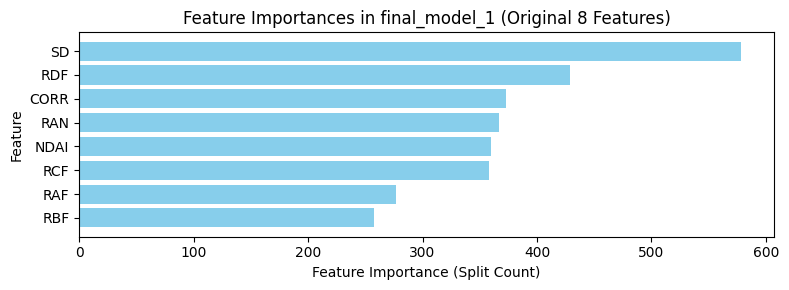

In [5]:
# Get feature importances
importances = final_model_1.feature_importance(importance_type='split')  # Split count
feature_names = X_test.columns

# Create a list of (feature, importance) tuples and sort by importance
feature_importance_pairs = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)

# Print all features
print("Feature Importances for final_model_1 (Original 8 Features):")
for name, imp in feature_importance_pairs:
    print(f"{name}: {imp}")

# Plot all 8 features
features = [pair[0] for pair in feature_importance_pairs]
importances = [pair[1] for pair in feature_importance_pairs]

plt.figure(figsize=(8, 3))
plt.barh(features, importances, color='skyblue')
plt.xlabel('Feature Importance (Split Count)')
plt.ylabel('Feature')
plt.title('Feature Importances in final_model_1 (Original 8 Features)')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.tight_layout()
plt.show()

2. Now testing lightGBM on df with **additional 32 ae_features**

In [6]:
# Load the three csv files from data_labeled
image_1 = pd.read_csv('../data/data_labeled/image1_ae.csv') 
image_2 = pd.read_csv('../data/data_labeled/image2_ae.csv')
image_3 = pd.read_csv('../data/data_labeled/image3_ae.csv')

In [7]:
#Rename the first two columns!!! convert from x,y to X,Y
image_1 = image_1.rename(columns={'y': 'Y', 'x': 'X'})
image_2 = image_2.rename(columns={'y': 'Y', 'x': 'X'})
image_3 = image_3.rename(columns={'y': 'Y', 'x': 'X'})

# Merge original feature with 32 additional features on X and Y coordinates
df1_new = pd.merge(df1, image_1, on=['X', 'Y'], how='inner')
df2_new = pd.merge(df2, image_2, on=['X', 'Y'], how='inner')
df3_new = pd.merge(df3, image_3, on=['X', 'Y'], how='inner')
#now each df has 43 columns. (8 original + 32 new ae features) 

In [8]:
# Prepare features and labels
X_df1 = df1_new.drop(columns=['X', 'Y', 'label'])  # 40 features
y_df1 = df1_new['label']
X_df2 = df2_new.drop(columns=['X', 'Y', 'label'])
y_df2 = df2_new['label']
X_test = df3_new.drop(columns=['X', 'Y', 'label'])
y_test = df3_new['label']

df_train = pd.concat([df1_new, df2_new])
X_train_full = df_train.drop(columns=['X', 'Y', 'label'])
y_train_full = df_train['label']

In [9]:
# Hyperparameter grid (adjusted for more features)
param_grid = {
    'num_leaves': [15, 31, 63],  # Increased due to 40 features
    'learning_rate': [0.01, 0.05, 0.1]
}

# Base parameters
base_params = {
    'objective': 'binary',
    'metric': 'binary_error',
    'boosting_type': 'gbdt',
    'feature_fraction': 0.7,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'max_bin': 127,
    'verbose': -1
}

# 2-Fold CV setup
folds = [(X_df1, y_df1, X_df2, y_df2), (X_df2, y_df2, X_df1, y_df1)]

# Hyperparameter tuning
best_params = None
best_avg_val_error = float('inf')

for num_leaves in param_grid['num_leaves']:
    for learning_rate in param_grid['learning_rate']:
        params = base_params.copy()
        params['num_leaves'] = num_leaves
        params['learning_rate'] = learning_rate
        
        val_errors = []
        print(f"Testing: num_leaves={num_leaves}, learning_rate={learning_rate}")
        
        for X_train, y_train, X_valid, y_valid in folds:
            train_data = lgb.Dataset(X_train, label=y_train)
            valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)
            
            model = lgb.train(
                params,
                train_data,
                num_boost_round=500,
                valid_sets=[valid_data],
                valid_names=['valid'],
                callbacks=[lgb.early_stopping(20, verbose=False)]
            )
            val_error = model.best_score['valid']['binary_error']
            val_errors.append(val_error)
        
        avg_val_error = np.mean(val_errors)
        print(f"Average Validation Error: {avg_val_error:.4f}")
        
        if avg_val_error < best_avg_val_error:
            best_avg_val_error = avg_val_error
            best_params = params

# Final output
print(f"\nBest Parameters: num_leaves={best_params['num_leaves']}, learning_rate={best_params['learning_rate']}")
print(f"Best Average Validation Error: {best_avg_val_error:.4f}")

# Retrain with best parameters
print("\nRetraining with best parameters...")
train_data_full = lgb.Dataset(X_train_full, label=y_train_full)
final_model_2 = lgb.train(
    best_params,
    train_data_full,
    num_boost_round=500
)

# Test on df3
y_pred_2 = final_model_2.predict(X_test)
y_pred_binary_2 = np.where(y_pred_2 > 0.5, 1, -1)
test_accuracy_model_2 = accuracy_score(y_test, y_pred_binary_2) 
test_error_2= 1 - test_accuracy_model_2
print(f"Test Error with 40 features df3: {test_error_2:.4f}")
print(f"Test Accuracy with 40 features df3: {test_accuracy_model_2:.4f}")

Testing: num_leaves=15, learning_rate=0.01
Average Validation Error: 0.3657
Testing: num_leaves=15, learning_rate=0.05
Average Validation Error: 0.1461
Testing: num_leaves=15, learning_rate=0.1
Average Validation Error: 0.1410
Testing: num_leaves=31, learning_rate=0.01
Average Validation Error: 0.1456
Testing: num_leaves=31, learning_rate=0.05
Average Validation Error: 0.1408
Testing: num_leaves=31, learning_rate=0.1
Average Validation Error: 0.1415
Testing: num_leaves=63, learning_rate=0.01
Average Validation Error: 0.1486
Testing: num_leaves=63, learning_rate=0.05
Average Validation Error: 0.1498
Testing: num_leaves=63, learning_rate=0.1
Average Validation Error: 0.1477

Best Parameters: num_leaves=31, learning_rate=0.05
Best Average Validation Error: 0.1408

Retraining with best parameters...
Test Error with 40 features df3: 0.0758
Test Accuracy with 40 features df3: 0.9242


Seems that the model with all the features (original + ae_features) seems better. 
Now we will draw confusion matrices for both models, to compare side by side.

Code for Confusion Matrix!!!

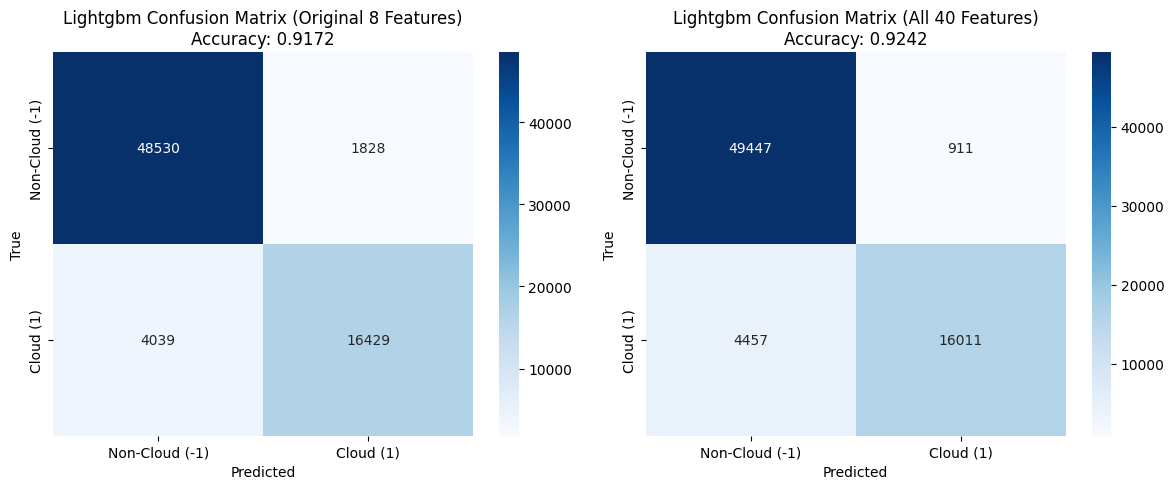

In [10]:
# Compute confusion matrices
cm_1 = confusion_matrix(y_test, y_pred_binary_1)
cm_2 = confusion_matrix(y_test, y_pred_binary_2)

# Compute accuracies (for reference)
acc_1 = accuracy_score(y_test, y_pred_binary_1)
acc_2 = accuracy_score(y_test, y_pred_binary_2)

# Plot confusion matrices side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Original features
sns.heatmap(cm_1, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['Non-Cloud (-1)', 'Cloud (1)'],
            yticklabels=['Non-Cloud (-1)', 'Cloud (1)'])
ax1.set_title(f'Lightgbm Confusion Matrix (Original 8 Features)\nAccuracy: {acc_1:.4f}')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('True')

# All features
sns.heatmap(cm_2, annot=True, fmt='d', cmap='Blues', ax=ax2,
            xticklabels=['Non-Cloud (-1)', 'Cloud (1)'],
            yticklabels=['Non-Cloud (-1)', 'Cloud (1)'])
ax2.set_title(f'Lightgbm Confusion Matrix (All 40 Features)\nAccuracy: {acc_2:.4f}')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('True')
plt.savefig("../figures/lightgbm_cm.png", dpi=300)
plt.tight_layout()
plt.show()

It seems that the model with only the original 8 features is a little bit worse than the one with all 40 features, however model 1 is better in terms of True Positives (correctly classifying as clouds)

The model with 40 features improves accuracy by 0.7% (absolute), a modest but meaningful gain. This suggests the 32 autoencoded features add predictive power, though not dramatically.

- 40 Features Help: The autoencoded features improve overall accuracy (92.42% vs. 91.72%) by significantly reducing false positives (non-cloud misclassified as cloud). This is valuable if false positives are costly (e.g., over-predicting clouds in weather models).
- Trade-Off: The model sacrifices some recall for clouds (more false negatives), meaning it misses more cloud pixels. If missing clouds is critical (e.g., for safety in satellite imaging), this might be a concern.

In [11]:
# 1. Precision, Recall, F1 Score
# Compute for both models (for the positive class: Cloud, label=1)
precision_1, recall_1, f1_1, _ = precision_recall_fscore_support(y_test, y_pred_binary_1, average='binary', pos_label=1)
precision_2, recall_2, f1_2, _ = precision_recall_fscore_support(y_test, y_pred_binary_2, average='binary', pos_label=1)

print("Model 1 (final_model_1):")
print(f"Precision: {precision_1:.4f}, Recall: {recall_1:.4f}, F1 Score: {f1_1:.4f}")
print("Model 2 (final_model_2):")
print(f"Precision: {precision_2:.4f}, Recall: {recall_2:.4f}, F1 Score: {f1_2:.4f}")

Model 1 (final_model_1):
Precision: 0.8999, Recall: 0.8027, F1 Score: 0.8485
Model 2 (final_model_2):
Precision: 0.9462, Recall: 0.7822, F1 Score: 0.8564


In [12]:
# 2. Approximate AIC
# For LightGBM, we approximate AIC using log-loss (binary cross-entropy)
# AIC = 2k - 2*ln(L), where ln(L) is approximated via log-loss
# k = number of parameters (approximated as number of features + 1 for intercept-like term)

# Number of features
k_1 = 8   # final_model_1 (original 8 features)
k_2 = 40  # final_model_2 (8 original + 32 autoencoded)

# Compute log-loss (requires probability predictions)
logloss_1 = log_loss(y_test, y_pred_1, labels=[-1, 1])
logloss_2 = log_loss(y_test, y_pred_2, labels=[-1, 1])

# Approximate AIC: 2k + n * logloss (since logloss = -ln(L)/n, so -ln(L) = n * logloss)
n = len(y_test)
aic_1 = 2 * k_1 + n * logloss_1
aic_2 = 2 * k_2 + n * logloss_2

print("\nApproximate AIC:")
print(f"Model 1 (final_model_1): {aic_1:.2f}")
print(f"Model 2 (final_model_2): {aic_2:.2f}")


Approximate AIC:
Model 1 (final_model_1): 14048.86
Model 2 (final_model_2): 19438.33


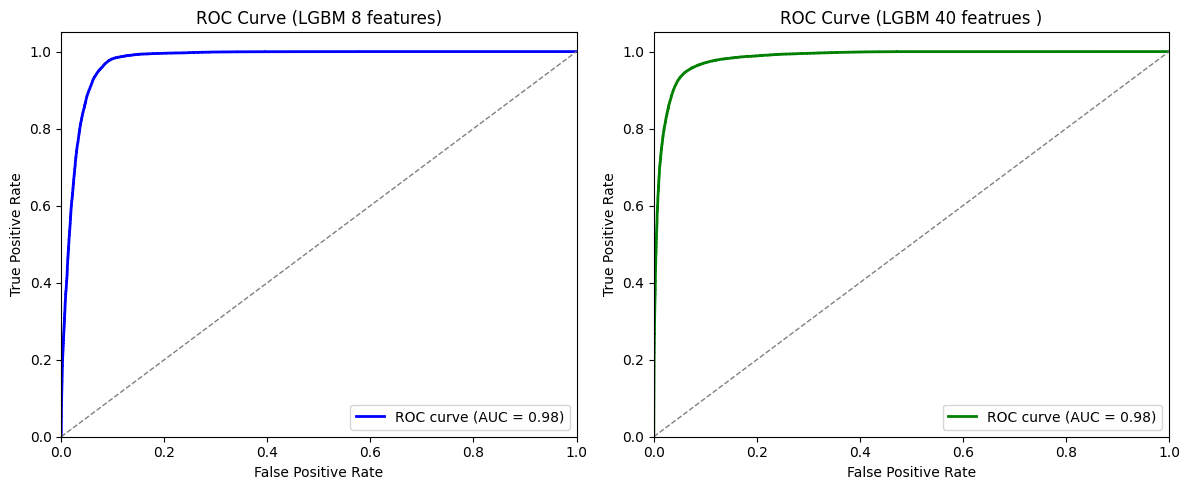

In [13]:
# 3. ROC Curve
# Compute ROC curves and AUC
fpr_1, tpr_1, _ = roc_curve(y_test, y_pred_1, pos_label=1)
roc_auc_1 = auc(fpr_1, tpr_1)

fpr_2, tpr_2, _ = roc_curve(y_test, y_pred_2, pos_label=1)
roc_auc_2 = auc(fpr_2, tpr_2)

# Plot ROC curves side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Model 1
ax1.plot(fpr_1, tpr_1, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc_1:.2f})')
ax1.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve (LGBM 8 features)')
ax1.legend(loc="lower right")

# Model 2
ax2.plot(fpr_2, tpr_2, color='green', lw=2, label=f'ROC curve (AUC = {roc_auc_2:.2f})')
ax2.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve (LGBM 40 featrues )')
ax2.legend(loc="lower right")
plt.savefig("../figures/lightgbm_roc.png", dpi=300)
plt.tight_layout()
plt.show()

Top 20 Most Important Features:
ae27: 812
ae7: 754
ae20: 597
SD: 559
ae0: 559
ae11: 529
ae18: 517
ae29: 512
ae3: 504
ae9: 499
ae21: 491
ae23: 418
ae30: 410
ae22: 408
ae13: 392
ae12: 388
ae6: 385
ae25: 385
ae16: 369
ae5: 362


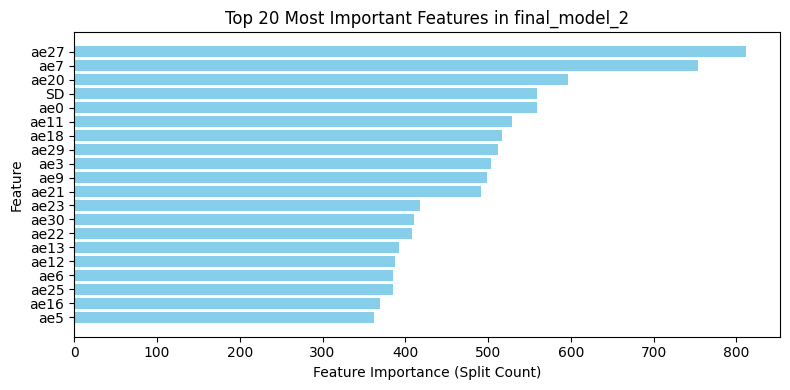

In [14]:
# Get feature importances
importances = final_model_2.feature_importance(importance_type='split')  # 'split' or 'gain'
feature_names = X_test.columns

# Create a list of (feature, importance) tuples
feature_importance_pairs = list(zip(feature_names, importances))

# Sort by importance in descending order
feature_importance_pairs = sorted(feature_importance_pairs, key=lambda x: x[1], reverse=True)

# Print top 20 features
print("Top 20 Most Important Features:")
for name, imp in feature_importance_pairs[:20]:
    print(f"{name}: {imp}")

# Plot top 10 features
top_20_features = [pair[0] for pair in feature_importance_pairs[:20]]
top_20_importances = [pair[1] for pair in feature_importance_pairs[:20]]

plt.figure(figsize=(8, 4))
plt.barh(top_20_features, top_20_importances, color='skyblue')
plt.xlabel('Feature Importance (Split Count)')
plt.ylabel('Feature')
plt.title('Top 20 Most Important Features in final_model_2')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.tight_layout()
plt.show()

The bar chart displays the top 10 most important features in final_model_all, which was trained on 40 features (8 original + 32 autoencoded) for cloud vs. non-cloud pixel classification task. The importance is measured by "split count," meaning how often each feature was used to split nodes across all trees in the LightGBM model. 

**Dominance of Autoencoded Features:**
Nine out of the top 10 features are autoencoded (ae27, ae7, ae20, etc.), indicating that the 32 autoencoded features are driving most of the model’s decision-making.
This aligns with confusion matrix results, where the 40-feature model improved accuracy (92.42% vs. 91.72%) over the 8-feature model. The autoencoded features are clearly adding predictive power.

In [15]:
df3_new['label'].value_counts()

label
-1.0    50358
 1.0    20468
Name: count, dtype: int64

Draw plots for post-hoc EDA!!!!

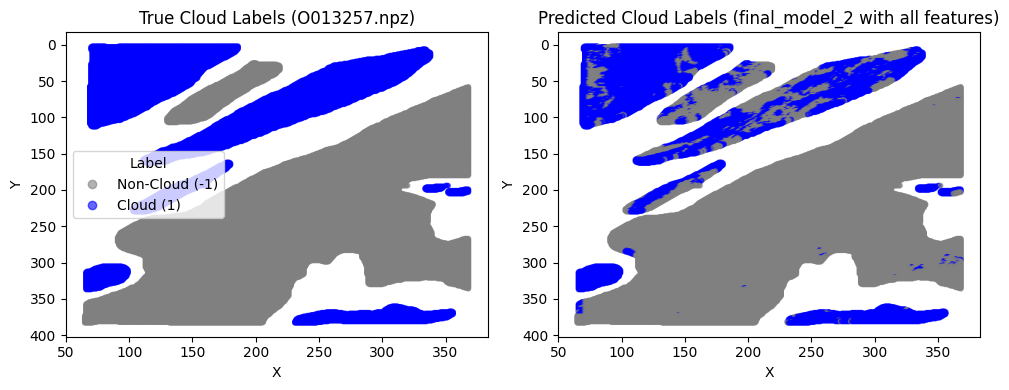

In [16]:
#plots for test picture
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Assuming df3_new and y_pred_binary_2 are already defined
# Create a dataframe with X, Y, true labels, and predicted labels
plot_df = pd.DataFrame({
    'X': df3_new['X'],
    'Y': df3_new['Y'],
    'True_Label': df3_new['label'],
    'Predicted_Label': y_pred_binary_2
})

# Define custom colormap: Non-Cloud (-1) -> grey, Cloud (1) -> blue
custom_cmap = ListedColormap(['grey', 'blue'])  # -1 (low) to 1 (high)

# 1. Scatter Plots (True vs. Predicted)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# True Labels
scatter1 = ax1.scatter(plot_df['X'], plot_df['Y'], c=plot_df['True_Label'], cmap=custom_cmap, s=10, alpha=0.6)
ax1.set_title('True Cloud Labels (O013257.npz)')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.invert_yaxis()
# Legend
handles1, labels1 = scatter1.legend_elements()
ax1.legend(handles=handles1, labels=['Non-Cloud (-1)', 'Cloud (1)'], title="Label")

# Predicted Labels
scatter2 = ax2.scatter(plot_df['X'], plot_df['Y'], c=plot_df['Predicted_Label'], cmap=custom_cmap, s=10, alpha=0.6)
ax2.set_title('Predicted Cloud Labels (final_model_2 with all features)')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.invert_yaxis()
# Legend
handles2, labels2 = scatter2.legend_elements()

plt.tight_layout()
plt.show()

The scatter plots show that final_model_all accurately identifies non-cloud pixels (gray) but struggles with cloud pixels (blue). This is likely due to the imbalanced dataset, with more non-cloud pixels (71%) than cloud pixels (29%), causing the model to favor non-cloud predictions, as seen in the increased false negatives (cloud pixels misclassified as non-cloud) in the predicted plot.

Now we check the prediction plots and the actual plots for the pictures used in train. 

In [17]:
#plot for two train pictures

#first fit the y_predict_binary_2 for df1 and df2
y_pred_2_1 = final_model_2.predict(X_df1) 
y_pred_2_2 = final_model_2.predict(X_df2) 
y_pred_binary_2_1 = np.where(y_pred_2_1 > 0.5, 1, -1) #get predicted binary values for df1
y_pred_binary_2_2 = np.where(y_pred_2_2 > 0.5, 1, -1) #get predicted binary values for df2


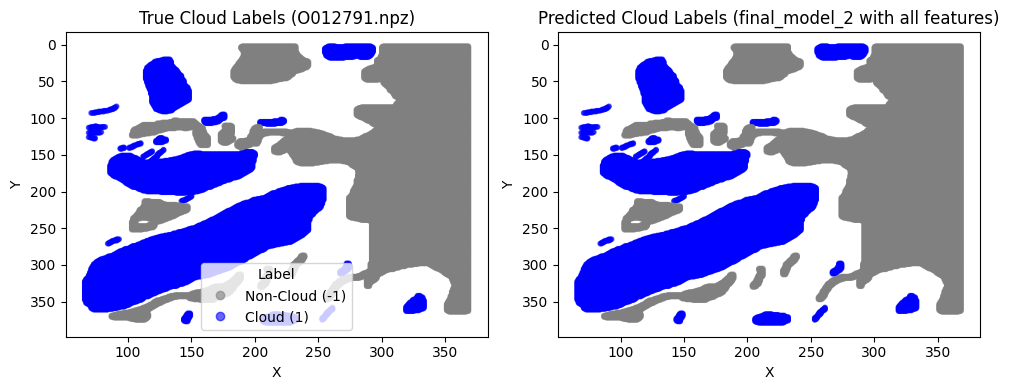

In [18]:
plot_df = pd.DataFrame({
    'X': df1_new['X'],
    'Y': df1_new['Y'],
    'True_Label': df1_new['label'],
    'Predicted_Label': y_pred_binary_2_1
})

# Define custom colormap: Non-Cloud (-1) -> grey, Cloud (1) -> blue
custom_cmap = ListedColormap(['grey', 'blue'])  # -1 (low) to 1 (high)

# 1. Scatter Plots (True vs. Predicted)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# True Labels
scatter1 = ax1.scatter(plot_df['X'], plot_df['Y'], c=plot_df['True_Label'], cmap=custom_cmap, s=10, alpha=0.6)
ax1.set_title('True Cloud Labels (O012791.npz)')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.invert_yaxis()
# Legend
handles1, labels1 = scatter1.legend_elements()
ax1.legend(handles=handles1, labels=['Non-Cloud (-1)', 'Cloud (1)'], title="Label")

# Predicted Labels
scatter2 = ax2.scatter(plot_df['X'], plot_df['Y'], c=plot_df['Predicted_Label'], cmap=custom_cmap, s=10, alpha=0.6)
ax2.set_title('Predicted Cloud Labels (final_model_2 with all features)')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.invert_yaxis()
# Legend
handles2, labels2 = scatter2.legend_elements()

plt.tight_layout()
plt.show()

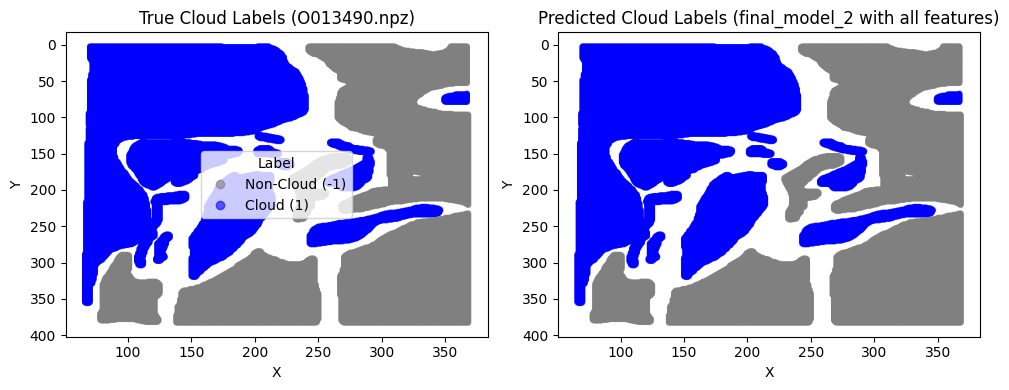

In [19]:
plot_df = pd.DataFrame({
    'X': df2_new['X'],
    'Y': df2_new['Y'],
    'True_Label': df2_new['label'],
    'Predicted_Label': y_pred_binary_2_2
})

# Define custom colormap: Non-Cloud (-1) -> grey, Cloud (1) -> blue
custom_cmap = ListedColormap(['grey', 'blue'])  # -1 (low) to 1 (high)

# 1. Scatter Plots (True vs. Predicted)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# True Labels
scatter1 = ax1.scatter(plot_df['X'], plot_df['Y'], c=plot_df['True_Label'], cmap=custom_cmap, s=10, alpha=0.6)
ax1.set_title('True Cloud Labels (O013490.npz)')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.invert_yaxis()
# Legend
handles1, labels1 = scatter1.legend_elements()
ax1.legend(handles=handles1, labels=['Non-Cloud (-1)', 'Cloud (1)'], title="Label")

# Predicted Labels
scatter2 = ax2.scatter(plot_df['X'], plot_df['Y'], c=plot_df['Predicted_Label'], cmap=custom_cmap, s=10, alpha=0.6)
ax2.set_title('Predicted Cloud Labels (final_model_2 with all features)')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.invert_yaxis()
# Legend
handles2, labels2 = scatter2.legend_elements()

plt.tight_layout()
plt.show()

We can clearly see that the prediction for the train pictures are nearly perfect. 


<h1>Stability check<h1>
<h2>Method 1: add random Gaussian error<h2>

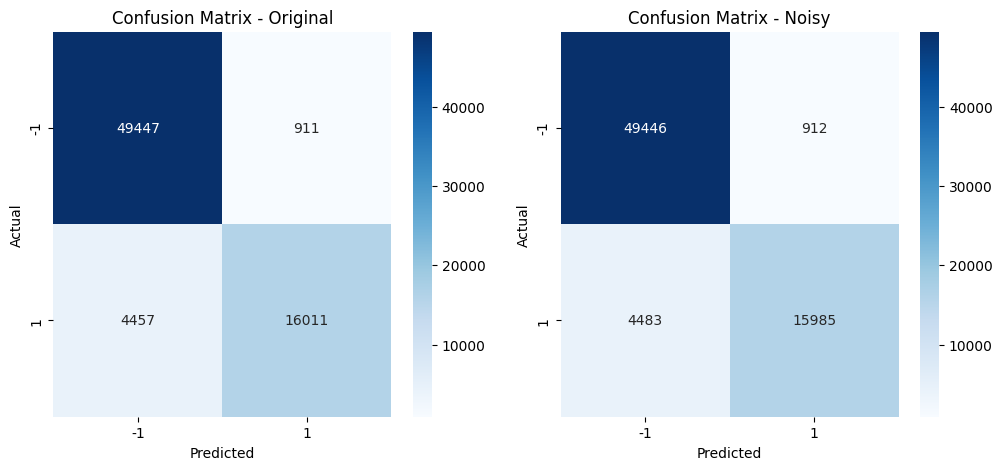

      Metric      Original    With Noise
0   Accuracy      0.924209      0.923827
1  Precision      0.946165      0.946026
2     Recall      0.782245      0.780975
3   F1 Score      0.856432      0.855614
4        AUC      0.983559      0.983489
5        AIC  19438.331387  19463.520997


In [20]:
# Copy the original test set
X_test_noisy = X_test.copy()

# Introduce Gaussian noise (1% of standard deviation for each feature)
noise_std = X_test.std() * 0.01
X_test_noisy += np.random.normal(loc=0, scale=noise_std, size=X_test.shape)

# Make predictions with original and noisy data using final_model_2
y_pred_prob = final_model_2.predict(X_test)
y_pred_binary = np.where(y_pred_prob > 0.5, 1, -1)

y_pred_prob_noisy = final_model_2.predict(X_test_noisy)
y_pred_binary_noisy = np.where(y_pred_prob_noisy > 0.5, 1, -1)

# Preserve 0 labels (unlabeled) in predictions
y_pred_binary[y_test == 0] = 0
y_pred_binary_noisy[y_test == 0] = 0

# Compute metrics for original test set (excluding unlabeled samples)
mask = y_test != 0
accuracy = accuracy_score(y_test[mask], y_pred_binary[mask])
precision, recall, f1, _ = precision_recall_fscore_support(y_test[mask], y_pred_binary[mask], average='binary')
auc = roc_auc_score(y_test[mask], y_pred_prob[mask])

# Compute log-loss and AIC
n = len(y_test[mask])
k_2 = 40  # Number of features in final_model_2
logloss = log_loss(y_test[mask], y_pred_prob[mask], labels=[-1, 1])
aic = 2 * k_2 + n * logloss

# Compute metrics for noisy test set (excluding unlabeled samples)
accuracy_noisy = accuracy_score(y_test[mask], y_pred_binary_noisy[mask])
precision_noisy, recall_noisy, f1_noisy, _ = precision_recall_fscore_support(y_test[mask], y_pred_binary_noisy[mask], average='binary')
auc_noisy = roc_auc_score(y_test[mask], y_pred_prob_noisy[mask])

# Compute log-loss and AIC for noisy set
logloss_noisy = log_loss(y_test[mask], y_pred_prob_noisy[mask], labels=[-1, 1])
aic_noisy = 2 * k_2 + n * logloss_noisy 

# Generate confusion matrices
conf_matrix_original = confusion_matrix(y_test[mask], y_pred_binary[mask], labels=[-1, 1])
conf_matrix_noisy = confusion_matrix(y_test[mask], y_pred_binary_noisy[mask], labels=[-1, 1])

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(conf_matrix_original, annot=True, fmt='d', cmap='Blues', xticklabels=[-1, 1], yticklabels=[-1, 1], ax=axes[0])
axes[0].set_title("Confusion Matrix - Original")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(conf_matrix_noisy, annot=True, fmt='d', cmap='Blues', xticklabels=[-1, 1], yticklabels=[-1, 1], ax=axes[1])
axes[1].set_title("Confusion Matrix - Noisy")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")
plt.savefig("../figures/perturbation_cm_lightgbm.png", dpi=300)
plt.show()

# Store stability results in DataFrame
stability_results = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score", "AUC", "AIC"],
    "Original": [accuracy, precision, recall, f1, auc, aic],
    "With Noise": [accuracy_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy, aic_noisy]
})

# Display results
print(stability_results)

<h2>Method 2: bootstrap<h2>

In [21]:
from scipy.stats import iqr
n_bootstrap = 10

# Store metrics for each bootstrap iteration
bootstrap_metrics = {
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1 Score": [],
    "AUC": [],
    "AIC": []
}

# Number of features in model
k_2 = 40  # Ensure this matches the number of features in your model

# Perform bootstrap resampling
for i in range(n_bootstrap):
    print(f"Bootstrap iteration {i+1}/{n_bootstrap}...")

    # Create bootstrap sample
    bootstrap_indices = np.random.choice(X_train_full.index, size=len(X_train_full), replace=True)
    X_train_bootstrap = X_train_full.loc[bootstrap_indices]
    y_train_bootstrap = y_train_full.loc[bootstrap_indices]

    # Train LightGBM model on bootstrap sample
    train_data_bootstrap = lgb.Dataset(X_train_bootstrap, label=y_train_bootstrap)
    model_bootstrap = lgb.train(best_params, train_data_bootstrap, num_boost_round=500)

    # Predict on the original test set
    y_pred_prob_bootstrap = model_bootstrap.predict(X_test)
    y_pred_binary_bootstrap = np.where(y_pred_prob_bootstrap > 0.5, 1, -1)

    # Compute metrics
    mask = y_test != 0  # Exclude unlabeled samples
    accuracy_bootstrap = accuracy_score(y_test[mask], y_pred_binary_bootstrap[mask])
    precision_bootstrap, recall_bootstrap, f1_bootstrap, _ = precision_recall_fscore_support(
        y_test[mask], y_pred_binary_bootstrap[mask], average='binary'
    )
    auc_bootstrap = roc_auc_score(y_test[mask], y_pred_prob_bootstrap[mask])
    logloss_bootstrap = log_loss(y_test[mask], y_pred_prob_bootstrap[mask], labels=[-1, 1])
    aic_bootstrap = 2 * k_2 + len(y_test[mask]) * logloss_bootstrap

    # Store results
    bootstrap_metrics["Accuracy"].append(accuracy_bootstrap)
    bootstrap_metrics["Precision"].append(precision_bootstrap)
    bootstrap_metrics["Recall"].append(recall_bootstrap)
    bootstrap_metrics["F1 Score"].append(f1_bootstrap)
    bootstrap_metrics["AUC"].append(auc_bootstrap)
    bootstrap_metrics["AIC"].append(aic_bootstrap)

# Convert to DataFrame
bootstrap_results = pd.DataFrame(bootstrap_metrics)

# Compute metric variation (Mean ± Standard Deviation)
summary_metrics = bootstrap_results.describe().T
summary_metrics["IQR"] = bootstrap_results.apply(iqr)  


display(summary_metrics)


Bootstrap iteration 1/10...
Bootstrap iteration 2/10...
Bootstrap iteration 3/10...
Bootstrap iteration 4/10...
Bootstrap iteration 5/10...
Bootstrap iteration 6/10...
Bootstrap iteration 7/10...
Bootstrap iteration 8/10...
Bootstrap iteration 9/10...
Bootstrap iteration 10/10...


,count,mean,std,min,25%,50%,75%,max,IQR
Accuracy,10.0,0.926253,0.001601,0.923206,0.925878,0.926305,0.926602,0.929419,0.000724
Precision,10.0,0.942811,0.001413,0.940604,0.941666,0.942805,0.944172,0.944537,0.002506
Recall,10.0,0.792906,0.005278,0.783760,0.790771,0.792921,0.794789,0.802912,0.004018
F1 Score,10.0,0.861378,0.003372,0.855049,0.860538,0.861567,0.862117,0.867985,0.001580
AUC,10.0,0.982787,0.000461,0.981792,0.982665,0.982738,0.983004,0.983597,0.000339
AIC,10.0,19158.332845,363.674696,18498.344255,18995.779335,19142.053308,19350.086809,19875.454702,354.307473


<h1>prediction on unlabeled dataset<h1>

In [ ]:
# read data
df_unlabeled1 = intodf('O002539.npz')
df_unlabeled2 = intodf('O002772.npz')
image_unlabeled1 = pd.read_csv('../data/data_test/image1_ae.csv')   #  In the github remote repository we will place unlabeled data 
image_unlabeled2 = pd.read_csv('../data/data_test/image2_ae.csv')   #  for testing in data/data_test directory
print(df_unlabeled1.shape)  # df_unlabeled1 match image_unlabeled1       #  so the path should be ../data/data_test/image1_ae.csv
print(df_unlabeled2.shape)  # df_unlabeled2 match image_unlabeled2
print(image_unlabeled1.shape)
print(image_unlabeled2.shape)

(115378, 10)
(115668, 10)
(115378, 34)
(115668, 34)


In [23]:
# merge
image_unlabeled1 = image_unlabeled1.rename(columns={'y': 'Y', 'x': 'X'})
image_unlabeled2 = image_unlabeled2.rename(columns={'y': 'Y', 'x': 'X'})
df_unlabeled1_new = pd.merge(df_unlabeled1, image_unlabeled1, on=['X', 'Y'], how='inner')
df_unlabeled2_new = pd.merge(df_unlabeled2, image_unlabeled2, on=['X', 'Y'], how='inner')
X_df_unlabeled1 = df_unlabeled1_new.drop(columns=['X', 'Y'])
X_df_unlabeled2 = df_unlabeled2_new.drop(columns=['X', 'Y'])
print(X_df_unlabeled1.shape)
print(X_df_unlabeled2.shape)

(115378, 40)
(115668, 40)


In [24]:
# make predictions
y_unlabled_pred1 = final_model_2.predict(X_df_unlabeled1) 
y_unlabled_pred2 = final_model_2.predict(X_df_unlabeled2) 
y_unlabled_pred1 = np.where(y_unlabled_pred1 > 0.5, 1, -1) 
y_unlabled_pred2 = np.where(y_unlabled_pred2 > 0.5, 1, -1) 

Figure saved: ../figures/O002772.png


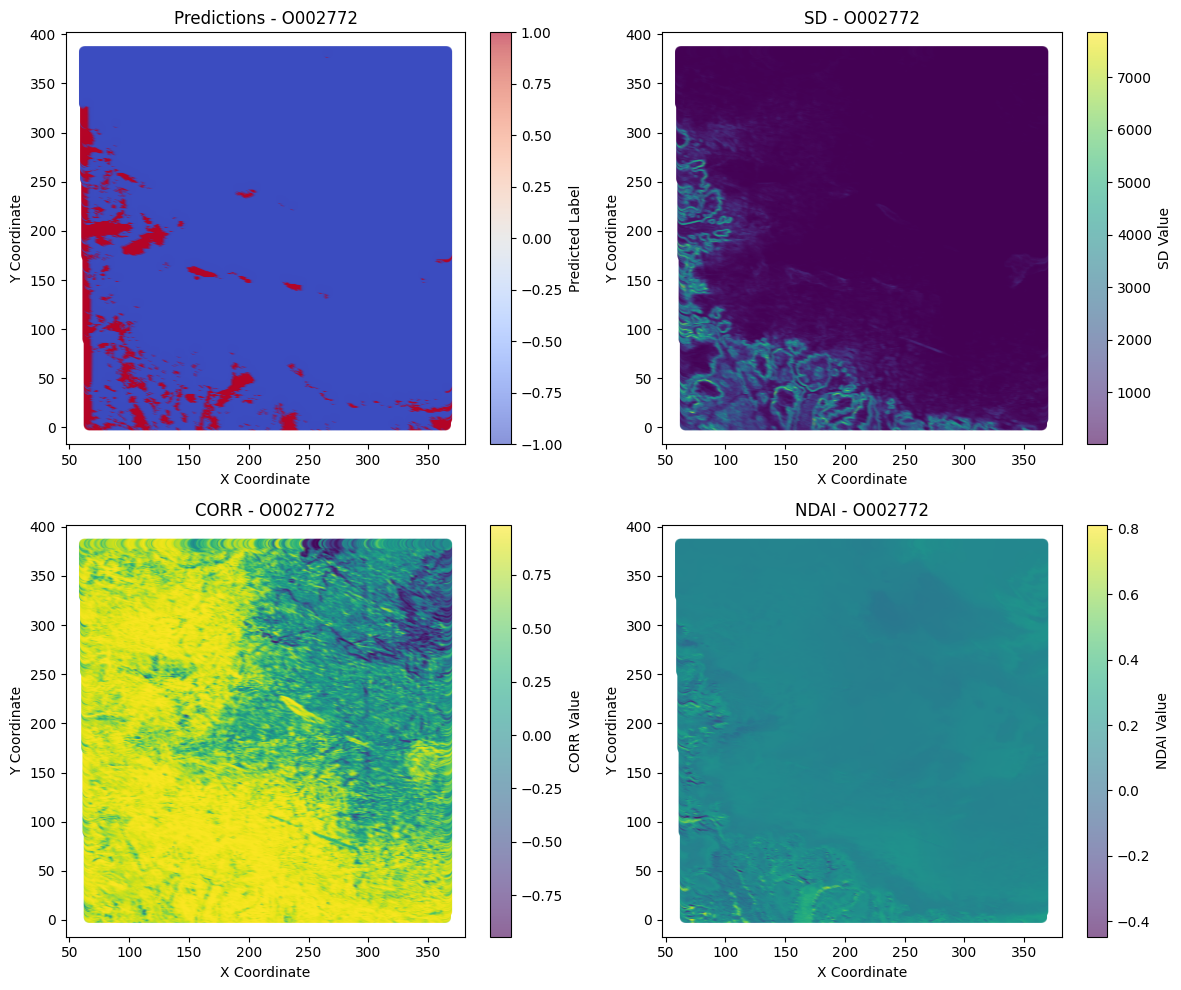

In [25]:
def plot_scatter(data, predictions, save_path):
    features = ['SD', 'CORR', 'NDAI']
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2x2 layout
    
    # Scatter plot for predictions
    scatter_pred = axes[0, 0].scatter(data['X'], data['Y'], c=predictions, cmap='coolwarm', alpha=0.6)
    axes[0, 0].set_title('Predictions - O002772')
    axes[0, 0].set_xlabel('X Coordinate')
    axes[0, 0].set_ylabel('Y Coordinate')
    fig.colorbar(scatter_pred, ax=axes[0, 0], label='Predicted Label')
    
    # Scatter plots for features
    for i, feature in enumerate(features):
        row, col = divmod(i + 1, 2)  # Arrange plots in 2x2
        if feature in data.columns:
            scatter_feat = axes[row, col].scatter(data['X'], data['Y'], c=data[feature], cmap='viridis', alpha=0.6)
            axes[row, col].set_title(f'{feature} - O002772')
            axes[row, col].set_xlabel('X Coordinate')
            axes[row, col].set_ylabel('Y Coordinate')
            fig.colorbar(scatter_feat, ax=axes[row, col], label=f'{feature} Value')
    
    plt.tight_layout()
    
    # Save the figure
    plt.savefig(save_path, dpi=300)  # High resolution for clarity
    print(f"Figure saved: {save_path}")
    
    plt.show()

# Generate and save scatter plot for O002772
plot_scatter(df_unlabeled2_new, y_unlabled_pred2, "../figures/O002772.png")